## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/14.Supervised_Learning/14.4.4.RandomForest Covid Case Study_06302020/')

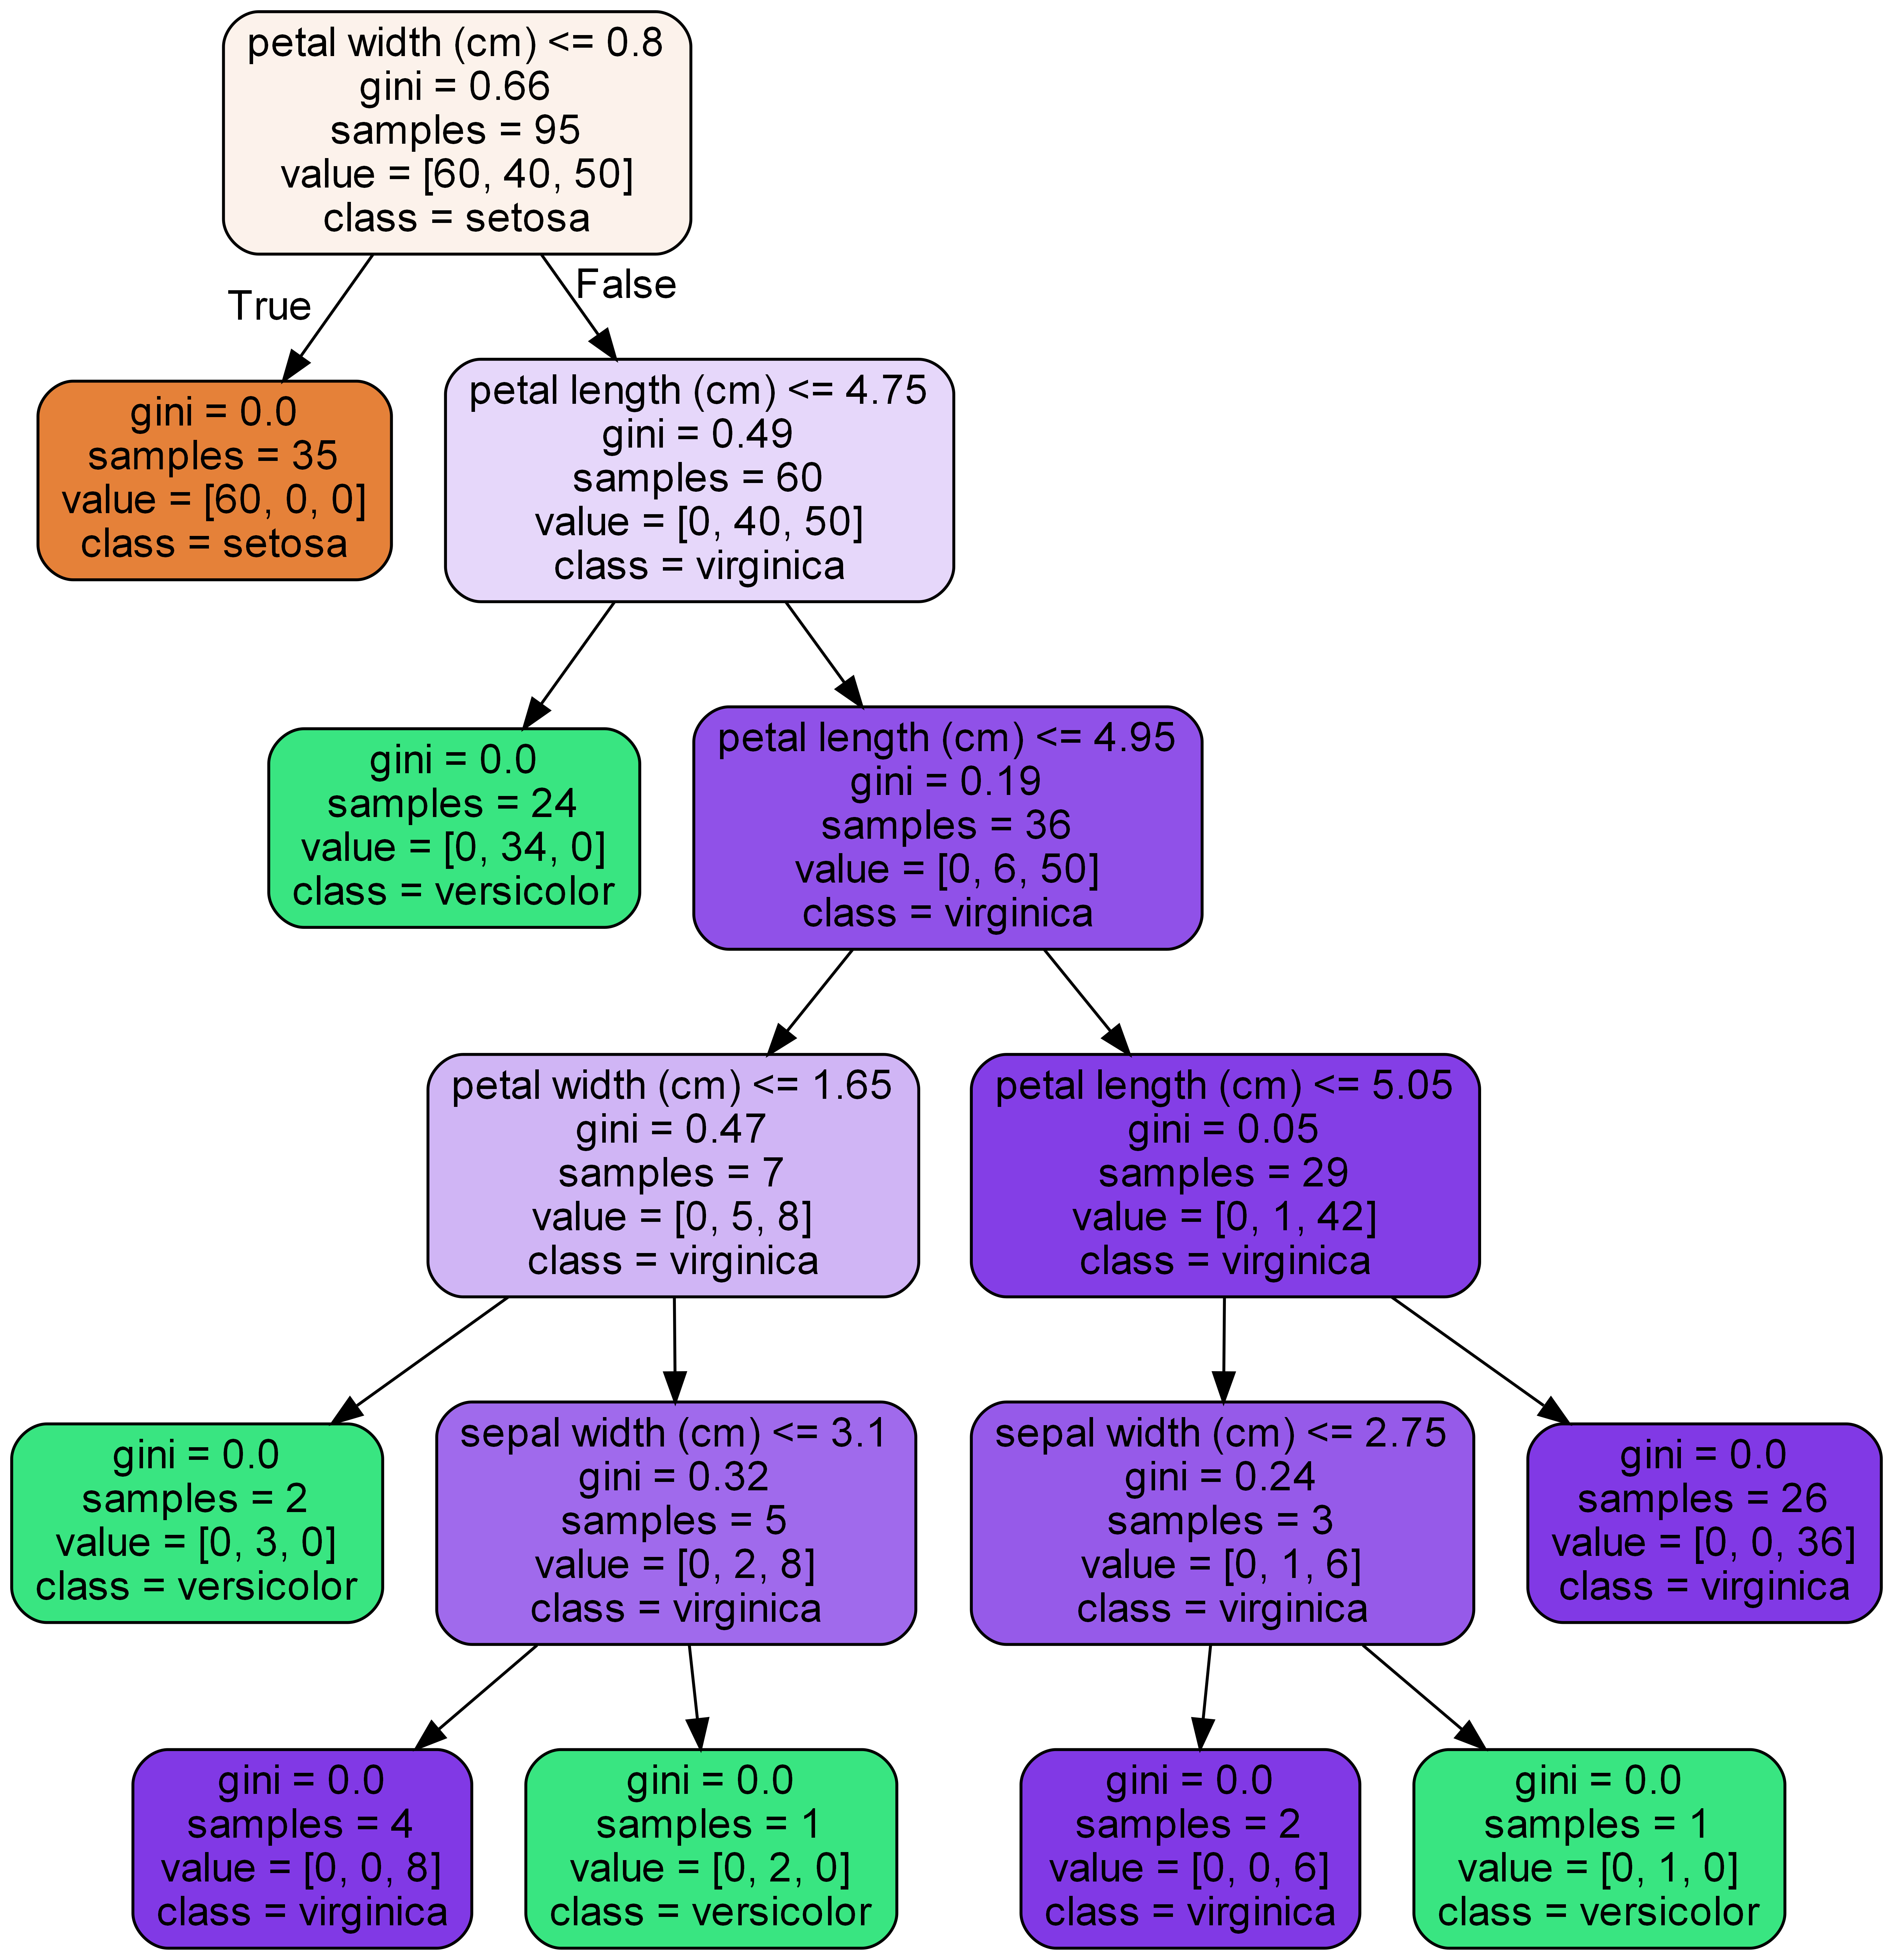

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split separates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [5]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#!pip install plotly
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [229]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
df.shape

(2218, 18)

In [230]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[na_df['NullCount']>0]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [231]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [232]:
df['n_age'] = 2020 - df.birth_year

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [233]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [235]:
df['disease'] = df['disease'].fillna(0).replace({True: 1})

In [236]:
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [237]:
for colname in {'global_num','birth_year','infection_order','infected_by','contact_number'}:
    mean_value = np.mean(df[colname])
    df[colname].fillna(value=mean_value, inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [238]:
# See which columns have missing values and how many of them 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          2218 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          2218 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             2218 non-null   int64  
 9   infection_case      1163 non-null   object 
 10  infection_order     2218 non-null   float64
 11  infected_by         2218 non-null   float64
 12  contact_number      2218 non-null   float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

The first column with missing values is `'sex'`.

In [239]:
df['sex'].value_counts()

female    1171
male       902
Name: sex, dtype: int64

In [240]:
N = df.shape[0]
print("Total participants =",N)
m = N - (1171 + 902)
print("Missing = ",m)
print("Females - Males = ",1171-902)

Total participants = 2218
Missing =  145
Females - Males =  269


Let's assume that all missing values are males. This will partially balance the difference between number of females and males.

In [241]:
df['sex'].fillna(value='male', inplace=True)

Column `'age'`. See possible levels.

In [242]:
df.age.value_counts()

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

Double-check your understanding of how categories are assigned. 

In [243]:
n=14 # record
print("Birth year =", df.birth_year[n])
print("Age =", 2020 - df.birth_year[n])
print("Age category =", df.age[n])

Birth year = 1943.0
Age = 77.0
Age category = 70s


In [244]:
def age_category(age):
    if age<10: return '0s'
    elif age<20: return '10s'
    elif age<30: return '20s'
    elif age<40: return '30s'
    elif age<50: return '40s'
    elif age<60: return '50s'
    elif age<70: return '60s'
    elif age<80: return '70s'
    elif age<90: return '80s'
    elif age<100: return '90s'
    else: return '100s'

In [245]:
df['age'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
2213    False
2214    False
2215    False
2216    False
2217    False
Name: age, Length: 2218, dtype: bool

In [246]:
# Fix categorical values of 'age'
for i, age in enumerate(df['age']):
    if pd.isna(age):
        #print(i,age,df.birth_year[i], age_category(2020 - df.birth_year[i]))
        df['age'].iloc[i] = age_category(2020 - df.birth_year[i])

C:\Programs\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Column `'city'`.

Let's use backward fill method, in the hope that upon arriving at another city, they forgot to put city name in the first record, but then did put it starting from the 2nd record. However, there is a risk of picking a city name from another province.

In [247]:
df['city'] = df['city'].fillna(method='bfill')
df.city.isnull().sum()

0

Column `'infection_case'`.

In [248]:
df['infection_case'].value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

Replacing null values with the mode 'contact with patient'.

In [249]:
df['infection_case'] = df['infection_case'].fillna(value='contact with patient')

Column `'symptom_onset_date'`. Let's replace missing values with the mean date.

In [250]:
ts=pd.Series(pd.to_datetime(df['symptom_onset_date']))
mean_time_datetime = ts.mean()
mean_time_str = mean_time_datetime.strftime("%Y-%m-%d")
print("Mean symptom onset date =",mean_time_str)

Mean symptom onset date = 2020-02-29


In [251]:
df['symptom_onset_date'] = df['symptom_onset_date'].fillna(value=mean_time_str)

Column `'confirmed_date'` is filled out using constant offset from 'symptom_onset_date'.

In [267]:
datetime_later = ( pd.to_datetime(df['confirmed_date']) - pd.to_datetime(df['symptom_onset_date']) ).mean()
days_later = datetime_later.days
print("Confirmed date is later than symptom onset on average by",days_later,"days")

Confirmed date is later than symptom onset on average by 2 days


In [272]:
for i, date in enumerate(df['confirmed_date']):
    if pd.isna(date):
        datetime = pd.to_datetime(df['symptom_onset_date'][i]) + datetime_later
        date_str = datetime.strftime("%Y-%m-%d")
        #print(i,date_str,df['symptom_onset_date'][i],date_str)
        df['confirmed_date'][i] = date_str

<ipython-input-272-e56fbbfb91a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confirmed_date'][i] = date_str


Column `'released_date'`.

In [276]:
datetime_later = ( pd.to_datetime(df['released_date']) - pd.to_datetime(df['symptom_onset_date']) ).mean()
days_later = datetime_later.days
print("Released date is later than confirmed on average by",days_later,"days")

Released date is later than confirmed on average by 10 days


In [278]:
for i, date in enumerate(df['released_date']):
    if pd.isna(date):
        datetime = pd.to_datetime(df['symptom_onset_date'][i]) + datetime_later
        date_str = datetime.strftime("%Y-%m-%d")
        #print(i,date,df['symptom_onset_date'][i],date_str)
        df['released_date'][i] = date_str

<ipython-input-278-43b466ede5bc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['released_date'][i] = date_str


Column `'deceased_date'`. Absence of value most probably indicates recovery, so let's just replace empty values by some past date.

In [288]:
df['deceased_date'].fillna(value='2000-01-01', inplace=True)

Column `'state'`.

In [294]:
df['state'].value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

It is reasonable to assume that there would be a record if a person was released. Assuming the missing values are 'isolated'.

In [295]:
df['state'].fillna(value='isolated', inplace=True)

Column `'n_age'`. Its missing values will be calculated as above, i.e., using 'birth_year'.

In [299]:
df['n_age'] = 2020 - df.birth_year

 **<font color='teal'> Check for any remaining null values.</font>**

In [301]:
df.isnull().sum()

patient_id            0
global_num            0
sex                   0
birth_year            0
age                   0
country               0
province              0
city                  0
disease               0
infection_case        0
infection_order       0
infected_by           0
contact_number        0
symptom_onset_date    0
confirmed_date        0
released_date         0
deceased_date         0
state                 0
n_age                 0
dtype: int64

In [302]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,2000-01-01,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-02-29,2020-01-30,2020-03-02,2000-01-01,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-02-29,2020-01-30,2020-02-19,2000-01-01,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,2000-01-01,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-02-29,2020-01-31,2020-02-24,2000-01-01,released,28.0


Remove date columns from the data.


In [303]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

<font color='red'><b>Q1. Not sure why they asked to fill out all missing values to then just drop most of the fixed columns. Or was it unnecessary to fix the columns that are dropped here?</b></font>

Review the count of unique values by column.

In [304]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [305]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
dtype: float64


Review the range of values per column.

In [306]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [307]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [315]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn = vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
4,city,134
3,province,17
5,infection_case,16
1,age,11
2,country,4
6,state,3
0,sex,2


**<font color='teal'> Plot the correlation heat map for the features.</font>**

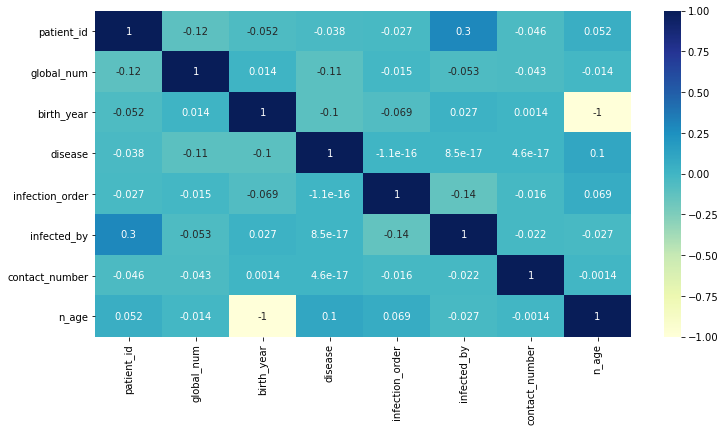

In [324]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [325]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28.0


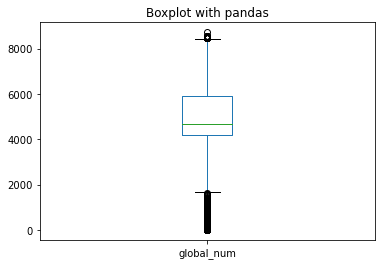

In [326]:
df['global_num'].plot.box(title='Boxplot with pandas');

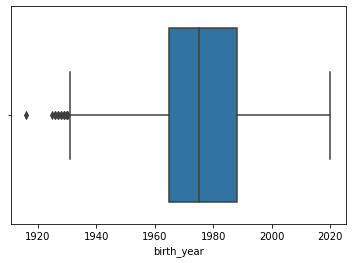

In [343]:
sns.boxplot(data=df, orient="h", x=df["birth_year"]);

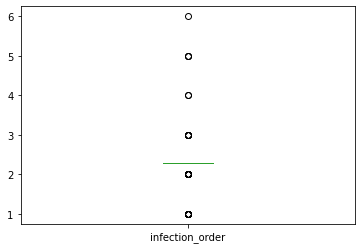

In [346]:
df['infection_order'].plot.box();

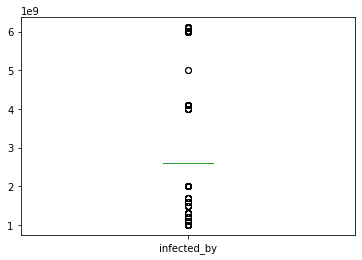

In [347]:
df['infected_by'].plot.box();

We can see many outlier values here. Not sure about the meaning of this variable.

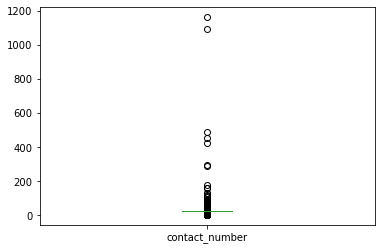

In [348]:
df['contact_number'].plot.box();

We can see many outlier values here, but they seem to be reasonable.

**<font color='teal'> Create dummy features for object type features. </font>**

In [372]:
df.select_dtypes(include=['object']) # list object type features

,sex,age,country,province,city,infection_case,state
0,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,released
1,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,released
2,male,50s,Korea,Seoul,Jongno-gu,contact with patient,released
3,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,released
4,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,released
5,female,50s,Korea,Seoul,Jongno-gu,contact with patient,released
6,male,20s,Korea,Seoul,Jongno-gu,contact with patient,released
7,male,20s,Korea,Seoul,etc,overseas inflow,released
8,male,30s,Korea,Seoul,Songpa-gu,overseas inflow,released
9,female,60s,Korea,Seoul,Seongbuk-gu,contact with patient,released


Column 'state' is the target variable, and thus should not be converted into dummy variables.

In [382]:
X = df.drop('state',axis=1)
y = df['state']

In [383]:
X = pd.get_dummies(X) # df with dummy variables 

In [384]:
for colname in X.columns:
    print(colname)

patient_id
global_num
birth_year
disease
infection_order
infected_by
contact_number
n_age
sex_female
sex_male
age_0s
age_100s
age_10s
age_20s
age_30s
age_40s
age_50s
age_60s
age_70s
age_80s
age_90s
country_China
country_Korea
country_Mongolia
country_Thailand
province_Busan
province_Chungcheongbuk-do
province_Chungcheongnam-do
province_Daegu
province_Daejeon
province_Gangwon-do
province_Gwangju
province_Gyeonggi-do
province_Gyeongsangbuk-do
province_Gyeongsangnam-do
province_Incheon
province_Jeju-do
province_Jeollabuk-do
province_Jeollanam-do
province_Sejong
province_Seoul
province_Ulsan
city_Andong-si
city_Ansan-si
city_Anseong-si
city_Anyang-si
city_Asan-si
city_Bonghwa-gun
city_Bucheon-si
city_Buk-gu
city_Bupyeong-gu
city_Busanjin-gu
city_Changnyeong-gun
city_Changwon-si
city_Cheonan-si
city_Cheongdo-gun
city_Cheongju-si
city_Cheongsong-gun
city_Chilgok-gun
city_Chunchun-si
city_Chungju-si
city_Daedeok-gu
city_Dalseo-gu
city_Dalseong-gun
city_Danyang-gun
city_Dobong-gu
city_Dong-gu


### Split the data into test and train subsamples

In [385]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [386]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [387]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import f1_score,auc,classification_report,confusion_matrix,precision_recall_curve,roc_curve,roc_auc_score,accuracy_score,log_loss

<font color='red'><b>Q2. Are we supposed to do Logistic Regression here? If so, how to handle 3 categories of the target variable? Or is that just a redundant line of code?</b></font>

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 86.5% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [388]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.865
Random Forest: f1-score=0.835


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [389]:
y.value_counts()

isolated    1879
released     307
deceased      32
Name: state, dtype: int64

In [391]:
class_names=['isolated','released','missing','deceased'] # names of classes

<font color='red'><b>Q3. Am I supposed to replace the missing values in the target column by 'missing' and include this category in the classification? It seems that in the beginning we were told to get rid of all missing values.</b></font>

In [392]:
class_names=['isolated','released','deceased'] # names of classes

Confusion matrix, without normalization
[[  6   1   0]
 [  0 362   6]
 [  0  53  16]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.98 0.02]
 [0.   0.77 0.23]]


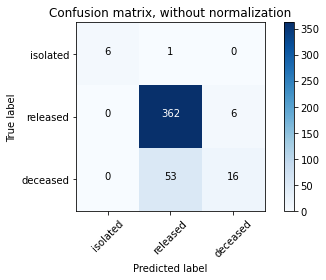

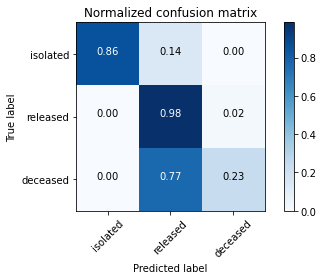

In [395]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


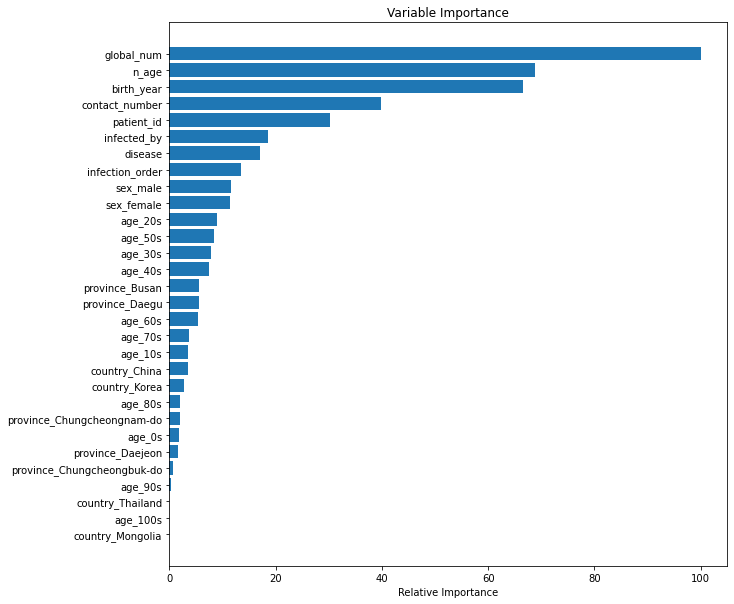

In [396]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, whereas a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.